In [1]:
import numpy as np
import pandas as pd
import glob
import unicodedata
import string
import os
import time
from io import open
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [2]:
def unicode_to_ascii(s):
    """Unicode string to plain ASCII.
    
    """
    decoded = "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )
    return decoded


def read_lines(filename):
    """Read a file and split into lines.
    
    """
    lines = open(filename, encoding="utf-8").read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


def letter_to_index(letter):
    """Find letter index from all_letters.
    
    """
    return all_letters.find(letter)


def category_to_tensor(category):
    """Get 1-hot encoding for a category 
    
    """
    cat_i = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][cat_i] = 1
    return tensor


def input_to_tensor(line):
    """Get 1-hot (line length, 1, n_letters) of first to last letters (not including EOS) for input.
    
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def target_to_tensor(line):
    """Long tensor of [line[1], line[2], ..., EOS].
    
    Skip line[0] since don't predict.
    
    """
    letter_indexes = [all_letters.find(line[i]) for i in range(1, len(line))]
    # Add EOS symbol
    letter_indexes.append(n_letters - 1)
    # (n,) -> (n,1)
    return torch.tensor(letter_indexes, dtype=torch.long)[:, None]


def random_pair():
    """Select a random training example and return category/line contents.
    
    """
    category = np.random.choice(all_categories)
    line = np.random.choice(category_lines[category])
    return category, line


def random_ex():
    """Make category, input, and target tensors from a random category, line pair
    
    """
    category, line = random_pair()
    category_tensor = category_to_tensor(category)
    input_line_tensor = input_to_tensor(line)
    target_line_tensor = target_to_tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [3]:
name_files = glob.glob("../data/rnn_char_class_data/names/*.txt")
all_letters = string.ascii_letters + " .,;'-"
# +1 is for EOS marker (EOS has index 1 past all_letters)
n_letters = len(all_letters) + 1

In [4]:
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-


In [5]:
# category_lines dict. -- a list of lines per category
category_lines = {}
all_categories = []

for filename in name_files:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
print('# categories:', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Korean', 'Vietnamese', 'Czech', 'French', 'Greek', 'Dutch', 'Irish', 'Japanese', 'Portuguese', 'Polish', 'Spanish', 'Scottish', 'German', 'Russian', 'English', 'Arabic', 'Chinese', 'Italian']
O'Neal


In [7]:
class RNN(nn.Module):
    def __init__(self, category_size, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.h1_fc = nn.Linear(category_size + input_size + hidden_size, hidden_size)
        self.y1_fc = nn.Linear(category_size + input_size + hidden_size, output_size)
        self.y2_fc = nn.Linear(hidden_size + output_size, output_size)
        
        self.tanh = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)
                
    def forward(self, c, x, h0):
        cxh0 = torch.cat((c, x, h0), dim=1)
        
        h1 = self.h1_fc(cxh0)
        h1 = self.tanh(h1)
        
        y = self.y1_fc(cxh0)
        y = self.tanh(y)
        
        yh1 = torch.cat((y, h1), dim=1)
        y = self.y2_fc(yh1)
        y = self.log_softmax(y)
        
        return y, h1
    
    def zero_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
def time_since(since):
    elapsed = time.time() - since
    m = elapsed // 60
    s = elapsed % 60
    return f"{m}m {s}s"


def train_line(model, crit, opt, category_tensor, input_line_tensor, target_line_tensor):    
    """Execute forward passes for one line.
    
    """
    opt.zero_grad()
    # Empty initial hidden state
    h = model.zero_hidden().to(device)
    loss = 0.0
    for i in range(input_line_tensor.size(0)):
        yhat, h = model(category_tensor, input_line_tensor[i], h)

        loss += crit(yhat, target_line_tensor[i])

    loss.backward()
    opt.step()
    
    return yhat, loss.item() / input_line_tensor.size(0)


def train():
    running_loss = 0.0
    losses = np.zeros(n_epochs // plot_every)
    
    model.train()
    
    start = time.time()
    for i in range(1, n_epochs + 1):
        for b in range(batch_size):
            category_tensor, input_line_tensor, target_line_tensor = random_ex()
            
            category_tensor, input_line_tensor, target_line_tensor = (
                category_tensor.to(device),
                input_line_tensor.to(device),
                target_line_tensor.to(device)
            )
            
            yhat, loss = train_line(model, criterion, optimizer, category_tensor, input_line_tensor, target_line_tensor)
            running_loss += loss
        
        if i % print_every == 0:
            print(f"{i} {np.round(i / n_epochs * 100, 0)}% ({time_since(start)}): {loss}")
        
        if i % plot_every == 0:
            # losses.append(running_loss / plot_every)
            losses[i // plot_every - 1] = running_loss / plot_every
            running_loss = 0.0
    
    return losses

In [9]:
n_hidden = 128
model = RNN(n_categories, n_letters, n_hidden, n_letters)

In [10]:
lr = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
batch_size = 32
n_epochs = 5000
print_every = 100
plot_every = print_every // 2
## Train on 1 line at a time, so GPU is slower
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [12]:
model.to(device)
losses = train()

100 2.0% (0.0m 11.38986587524414s): 2.6732425689697266
200 4.0% (0.0m 22.535061359405518s): 2.34039192199707
300 6.0% (0.0m 33.82731795310974s): 2.152622858683268
400 8.0% (0.0m 45.11534929275513s): 1.227890968322754
500 10.0% (0.0m 56.19987487792969s): 1.027355670928955
600 12.0% (1.0m 7.3309996128082275s): 1.9494984944661458
700 14.0% (1.0m 18.54298996925354s): 0.9609136581420898
800 16.0% (1.0m 29.669023990631104s): 2.3402607440948486
900 18.0% (1.0m 40.702229022979736s): 2.166274070739746
1000 20.0% (1.0m 51.88097643852234s): 2.011105946132115
1100 22.0% (2.0m 3.0012686252593994s): 2.1990555354527066
1200 24.0% (2.0m 14.082654476165771s): 1.5559584299723308
1300 26.0% (2.0m 25.17987608909607s): 1.8150856018066406
1400 28.0% (2.0m 36.326438665390015s): 1.482403310139974
1500 30.0% (2.0m 47.5848753452301s): 3.1449332237243652
1600 32.0% (2.0m 58.49946665763855s): 1.5962402025858562
1700 34.0% (3.0m 9.720534801483154s): 1.528820514678955
1800 36.0% (3.0m 20.85309362411499s): 3.0501177

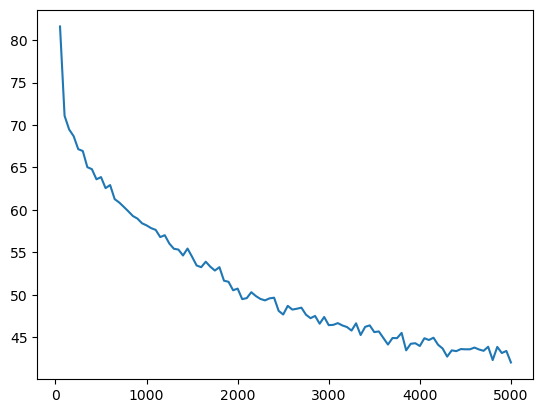

In [13]:
sns.lineplot(x=np.arange(plot_every, n_epochs + 1, plot_every), y=losses)
plt.show()

In [14]:
def sample(model, category, start_letter, max_length=50, k=1):
    model.eval()
    with torch.no_grad():
        h = model.zero_hidden().to(device)
        category_tensor = category_to_tensor(category).to(device)
        input_tensor = input_to_tensor(start_letter).to(device)
        
        output_name_ls = [start_letter]
        for i in range(max_length):
            yhat, h = model(category_tensor, input_tensor[0], h)
            topv, topi = yhat.topk(k)
            if topi.numel() > 1:
                topi = topi.squeeze().to("cpu").numpy()
                topv = topv.squeeze().to("cpu").numpy()
            else:
                topi = topi.squeeze(dim=1).to("cpu").numpy()
                topv = topv.squeeze(dim=1).to("cpu").numpy()
            topi = np.random.choice(topi, p=np.exp(topv)/np.sum(np.exp(topv)))
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name_ls.append(letter)
            input_tensor = input_to_tensor(letter)
    return "".join(output_name_ls)


def samples(model, category, start_letters, max_length=50, k=1):
    names = []
    for start_letter in start_letters:
        names.append(sample(model, category, start_letter, max_length=max_length, k=k))
    return names

In [30]:
samples(model, "Spanish", "G", k=1)

['Garcia']

In [197]:
def forward_through_seq(model, category_tensor, chars, prev_loglik):
    nc = len(chars)
    h = model.zero_hidden().to(device)
    loglik = torch.zeros(1, n_letters)
    # Log likelihood should start from previous -- before predicting
    # out to next character
    loglik[...] = prev_loglik
    
    for i, c in enumerate(chars):
        input_tensor = input_to_tensor(c).to(device)
        yhat, h = model(category_tensor, input_tensor[0], h)
        
        # When predicting final character, add on log likelihood
        if i == nc - 1:
            loglik += yhat
    # return loglik.squeeze(), nc + 1
    return loglik.squeeze()


def forward_first(model, category_tensor, chars):
    nc = len(chars)
    h = model.zero_hidden().to(device)
    loglik = torch.zeros(1, n_letters)
    for i, c in enumerate(chars):
        input_tensor = input_to_tensor(c).to(device)
        yhat, h = model(category_tensor, input_tensor[0], h)
        if i == nc - 1:
            loglik = yhat
    return loglik.squeeze()



def sample_beam(model, category, start_chars, max_length=50, k=3, n_keep=3):
    category_tensor = category_to_tensor(category).to(device)
    n_start = len(start_chars)
    
    # [(letters so far, log lik so far, last predicted index), ...]
    # 'Last predicted index' will have EOL character for strings that have ended
    # and last value of 'letters so far' for strings that are ongoing
    top_k = []
    
    model.eval()
    
    # Get top k initial predictions from starting character
    with torch.no_grad():
        initial_logliks = forward_first(model, category_tensor, start_chars)
        topv, topi = initial_logliks.topk(k)
        # Pre-squeezed
        topi = topi.to("cpu").numpy()
        topv = topv.to("cpu").numpy()
        for i, ti in enumerate(topi):
            # EOL or no?
            if ti == n_letters - 1:
                new_str = start_chars
            else:
                new_str = f"{start_chars}{all_letters[ti]}"
            top_k.append((new_str, float(topv[i]), ti))
    
    # Running sum of log likelihoods, for each of k best so far
    running_logliks = torch.zeros(k * n_letters)
    # Running count of letters for each of k best strings (for normalization)
    running_ns = torch.zeros(k * n_letters)
    
    with torch.no_grad():
        for _ in range(max_length - 1):
            # Which of k search slots are at EOL?
            eol_kslots = set()
            
            # For each of existing k best strings, get running log likelihood output for all
            # possible next characters
            for i, (chars, running_loglik, letter_idx) in enumerate(top_k):
                k_offset = i * n_letters
                # EOL or no?
                if letter_idx == n_letters - 1:
                    # If EOL, this string has already ended, don't want to start it up again
                    running_logliks[k_offset: k_offset + n_letters] = -torch.inf
                    # Set EOL slot to running log likelihood of existing (finished) string
                    running_logliks[k_offset + (n_letters - 1)] = running_loglik
                    running_ns[k_offset: k_offset + n_letters] = len(chars)
                    eol_kslots.add(i)
                else:                    
                    # Get next log likelihood
                    loglik = forward_through_seq(model, category_tensor, chars, running_loglik)
                    # Save running log likelihoods
                    running_logliks[k_offset: k_offset + n_letters] = loglik
                    running_ns[k_offset: k_offset + n_letters] = len(chars)
                    
            
            # all k best at eol?
            if len(eol_kslots) == k:
                break
    
            # Get k best normed log likelihoods
            # Normalize by (string length) - (num. starting characters) since we didn't
            # collect the likelihoods for the starting characters because they
            # are shared by all candidates
            topv, topi = (running_logliks / torch.pow(running_ns - n_start, 0.7)).topk(k)
            # Pre-squeezed
            topi = topi.to("cpu").numpy()
            topv = topv.to("cpu").numpy()

            top_k_new = []
            for i, ti in enumerate(topi):
                # Find out which top_k root this corresponds to
                k_slot = ti // n_letters
                # Update with ith best string & corresponding normed log likelhood
                if k in eol_kslots:
                    top_k_new.append((
                        top_k[k_slot][0],
                        top_k[k_slot][1],
                        top_k[k_slot][2]
                    ))
                else:
                    letter_idx = ti % n_letters
                    if letter_idx == n_letters - 1:
                        new_str = top_k[k_slot][0]
                    else:
                        new_str = f"{top_k[k_slot][0]}{all_letters[letter_idx]}"
                    top_k_new.append((
                        new_str,
                        float(topv[i]),
                        letter_idx
                    ))
            top_k = top_k_new
            # print(top_k)
    # Return sorted by log likelihood
    return sorted(top_k[:n_keep], key=lambda x: x[1], reverse=True)

In [221]:
res = sample_beam(model, "Spanish", "Gon", max_length=50, k=5, n_keep=5)
print(*res, sep='\n')
print()
res = sample_beam(model, "Irish", "O", max_length=50, k=5, n_keep=5)
print(*res, sep='\n')
print()
res = sample_beam(model, "Japanese", "Aki", max_length=50, k=5, n_keep=5)
print(*res, sep='\n')

('Gonzales', -0.16528040170669556, 58)
('Gonzalos', -0.18888409435749054, 58)
('Gonza', -0.24172276258468628, 58)
('Gonta', -0.3617638051509857, 58)
('Gonca', -0.39113518595695496, 58)

("O'Keefe", -0.0015345739666372538, 58)
("O'Keife", -0.002234239364042878, 58)
("O'Kealeri", -0.04866287112236023, 58)
("O'Donnell", -0.05042368546128273, 58)
("O'Kouferin", -0.22773849964141846, 58)

('Akimara', -0.2887316644191742, 58)
('Akisara', -0.3712746202945709, 58)
('Akita', -0.6650477051734924, 58)
('Akira', -0.7402023673057556, 58)
('Akisa', -0.7768906354904175, 58)
